# Portfolio analysis

## Case III : Stock prices from IPC Index

In [59]:
library('dplyr')
library('tidyverse')
library('Sim.DiffProc')
library('quadprog')
library('ggplot2')
library('plotly')
options(repr.plot.width=16, repr.plot.height=8)

In [60]:
source('./PortfolioFunctions_v1.r')

In [61]:
stock_prices <- read.csv('./df_IPC_MX.csv')%>%
  mutate(Date=as.Date(Date,format = "%Y-%m-%d"))
head(stock_prices)

,Date,MEGACPO.MX,ALSEA.MX,AC.MX,KIMBERA.MX,AMXL.MX,GRUMAB.MX,GCARSOA1.MX,BIMBOA.MX,GCC.MX,OMAB.MX,PINFRA.MX,GMEXICOB.MX,FEMSAUBD.MX,GAPB.MX,ASURB.MX,TLEVISACPO.MX,CEMEXCPO.MX,GFNORTEO.MX
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2008-01-03,36.50,14.6788,37.55,14.8000,16.275,34.4552,19.1063,14.9400,68.95,34.20,36.76,21.9838,40.89,48.03,65.91,50.23,19.8902,43.40
2,2008-01-04,36.31,14.4548,38.77,14.3733,15.990,34.2317,18.8179,14.4900,66.42,33.39,35.51,21.2622,39.10,47.09,67.07,49.56,19.2649,42.35
3,2008-01-07,36.00,14.4353,38.00,14.3300,15.805,33.1921,18.9254,14.1475,65.00,32.22,33.99,20.8449,40.49,47.61,66.92,49.53,19.0190,42.64
4,2008-01-08,36.25,13.9970,37.00,14.5133,16.085,32.6868,18.8619,13.9100,64.00,32.08,33.19,21.4567,41.25,49.43,66.75,49.34,19.1244,43.05
5,2008-01-09,36.19,13.6365,36.72,14.7867,16.150,32.5119,19.6148,14.3150,64.00,32.88,33.41,21.3092,40.65,50.94,65.59,49.33,19.0471,42.18
6,2008-01-10,36.00,13.6268,35.89,14.8000,16.585,32.3564,19.9863,14.4950,63.40,32.74,32.96,21.2810,41.80,51.43,66.52,50.90,19.5038,44.16


In [77]:
# get portfolio MV model
port.mv <- getPortfolio(base=stock_prices,year_to_start='2013',rebalance_period=24,mod='mv')

Estimated period : 2013-01 
Estimated period : 2015-01 
Estimated period : 2017-01 
Estimated period : 2019-01 
Estimated period : 2021-01 


In [78]:
# get portfolio MV-GBM model
port.mv_gbm <- getPortfolio(base=stock_prices,year_to_start='2013',rebalance_period=24,mod='gbm')

Estimated period : 2013-01 
Estimated period : 2015-01 
Estimated period : 2017-01 
Estimated period : 2019-01 
Estimated period : 2021-01 


In [83]:
#  Portfolio return
names <- c('date','MV','MV-GBM','MV-EW','MV-RW')
portfolio.ret <- data.frame('date' = port.mv$df.port.ret$date,
                       'MV'= port.mv$df.port.ret$min.ret,
                       'MV.GBM'= port.mv_gbm$df.port.ret$min.ret,
                       'MV.EW' = port.mv$df.port.ret$eqw.ret,
                       'MV.RW' = port.mv$df.port.ret$ran.ret)

In [84]:
# Cumulative portfolio
port.cum.ret <- portfolio.ret %>%
  mutate(cum.MV = cumsum(MV),
         cum.MV.GBM = cumsum(MV.GBM),
         cum.MV.EW = cumsum(MV.EW),
         cum.MV.RW = cumsum(MV.RW)) %>%
  dplyr::select(-MV,-MV.GBM,-MV.EW,-MV.RW)

In [85]:
# names
names2 <- c('date','MV-GBM minus MV','MV-GBM minus MV-EW','MV-GBM minus MV-RW')
cum.portfolio.diff <- port.cum.ret %>%
  mutate(MV.GBM_MV = cum.MV.GBM - cum.MV,
         MV.GBM_MV.EW =cum.MV.GBM - cum.MV.EW,
         MV.GBM_MV.RW = cum.MV.GBM - cum.MV.RW)%>%
  dplyr::select(-cum.MV,-cum.MV.GBM,-cum.MV.EW,-cum.MV.RW)

## colnames
colnames(portfolio.ret) <- names
colnames(port.cum.ret) <- names
colnames(cum.portfolio.diff) <- names2

In [86]:
# base cum.ret
base.cum.ret <- port.cum.ret %>%
  gather(key='Modelo',value='cumulative.return',-date)
# base cum.ret.diff
base.portfolio.diff <- cum.portfolio.diff %>%
  gather(key='Modelo',value='cumulative.return.diff',-date)

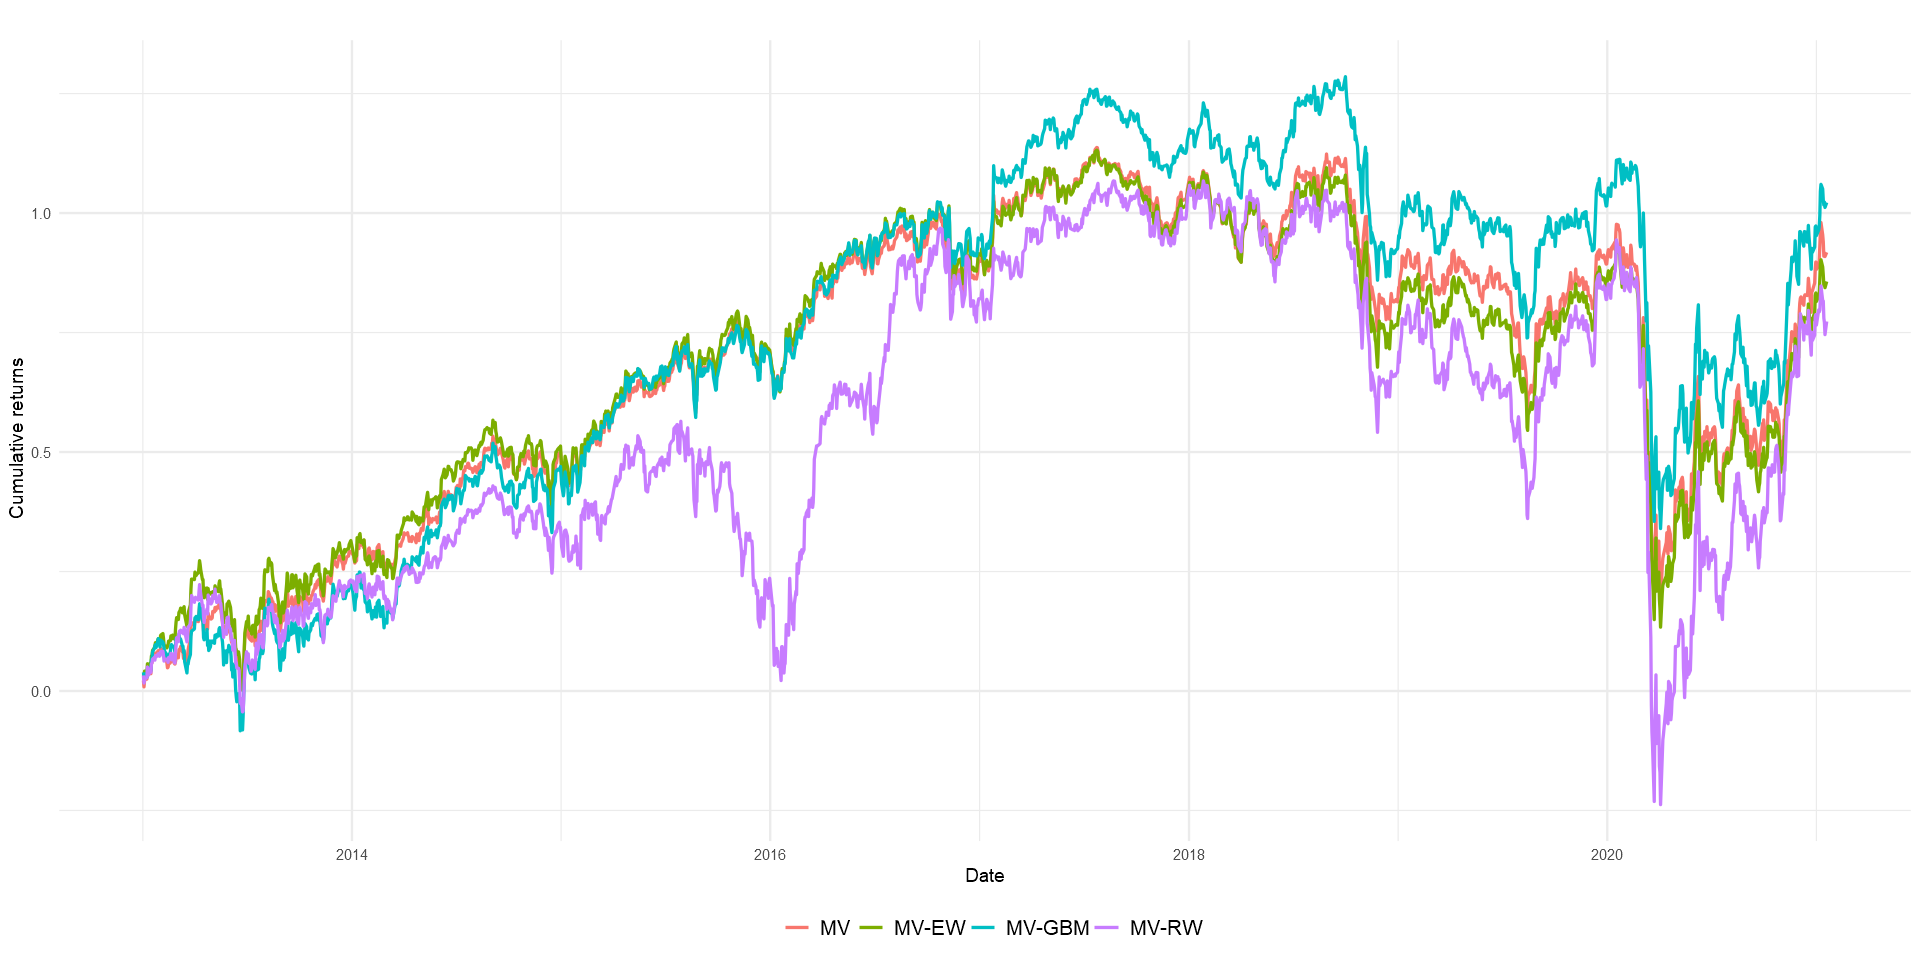

In [87]:
p0 <- ggplot(base.cum.ret , aes(x=date,y=cumulative.return,col=Modelo) )+
  geom_line(size=0.7) +
  theme_minimal() +
  theme(legend.position="bottom",
        legend.title = element_blank(),
        legend.text = element_text(colour="black", size=12)) +
  labs(title="",x='Date',y='Cumulative returns') 
p0

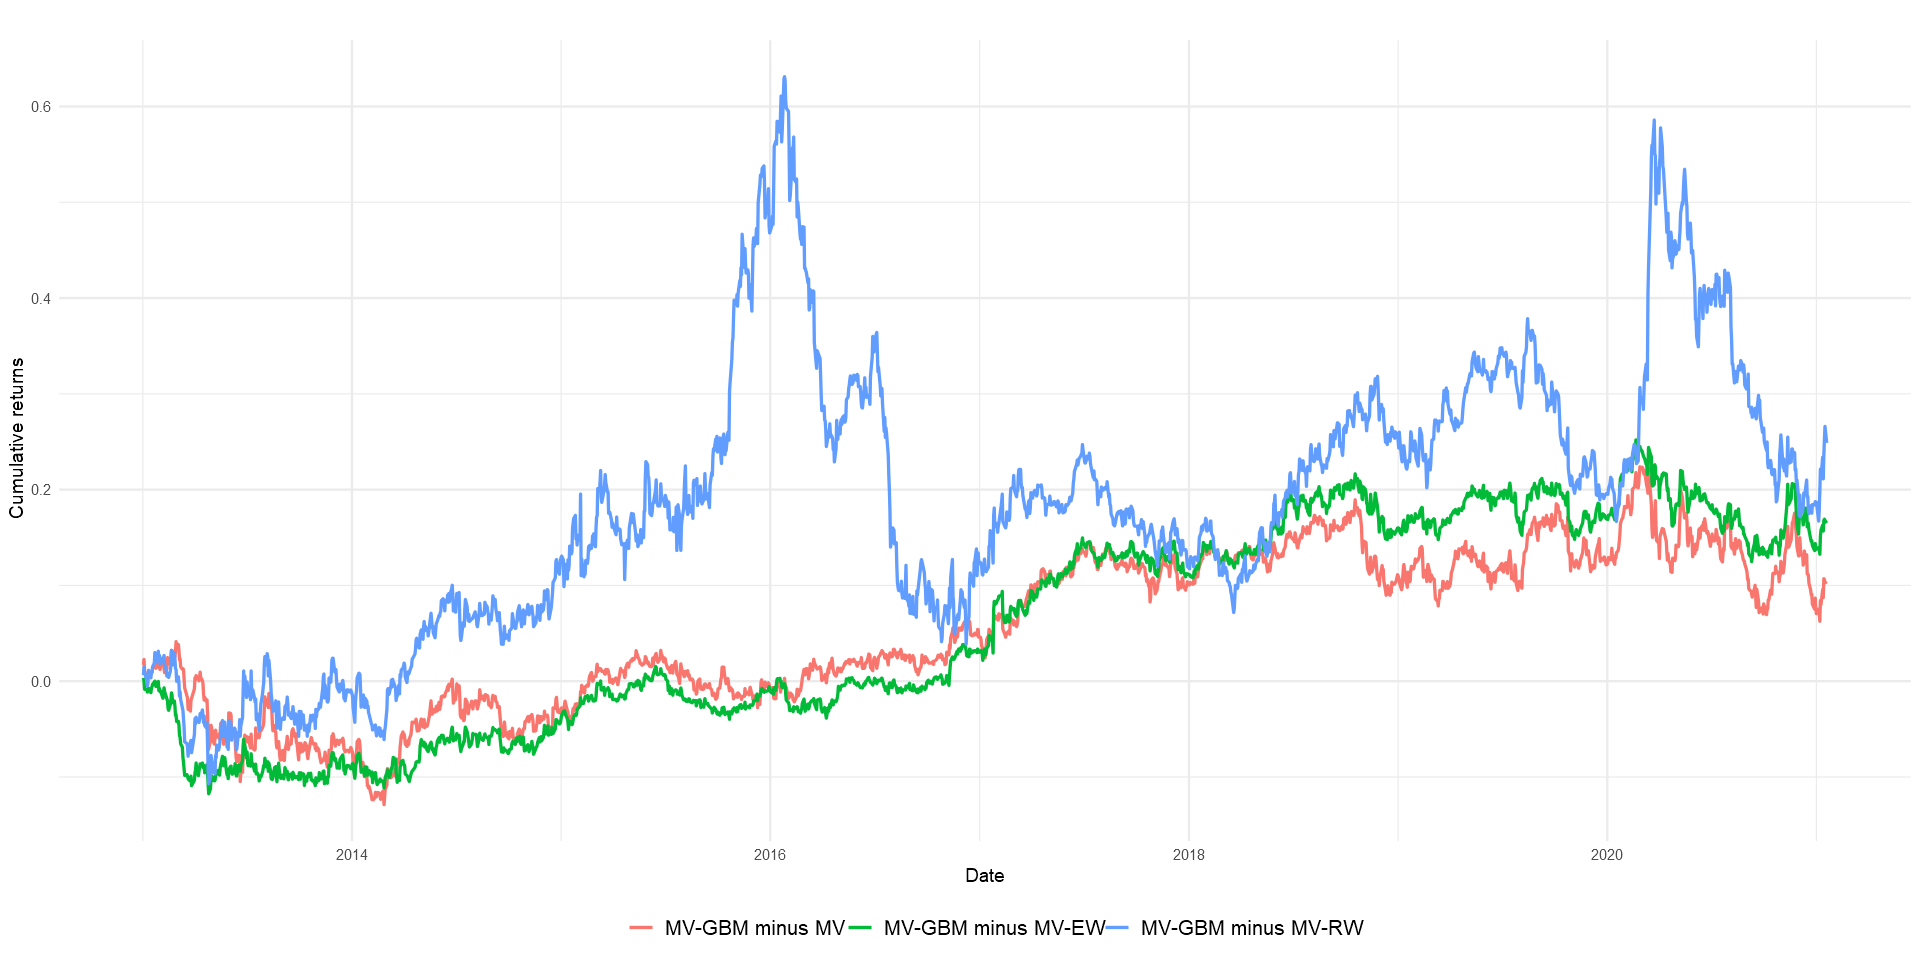

In [88]:
# differences
p1 <- ggplot(base.portfolio.diff , aes(x=date,y=cumulative.return.diff,col=Modelo) )+
  geom_line(size=0.7) +
  theme_minimal() +
  theme(legend.position="bottom",
        legend.title = element_blank(),
        legend.text = element_text(colour="black", size=12)) +
  labs(title="",x='Date',y='Cumulative returns') 
p1

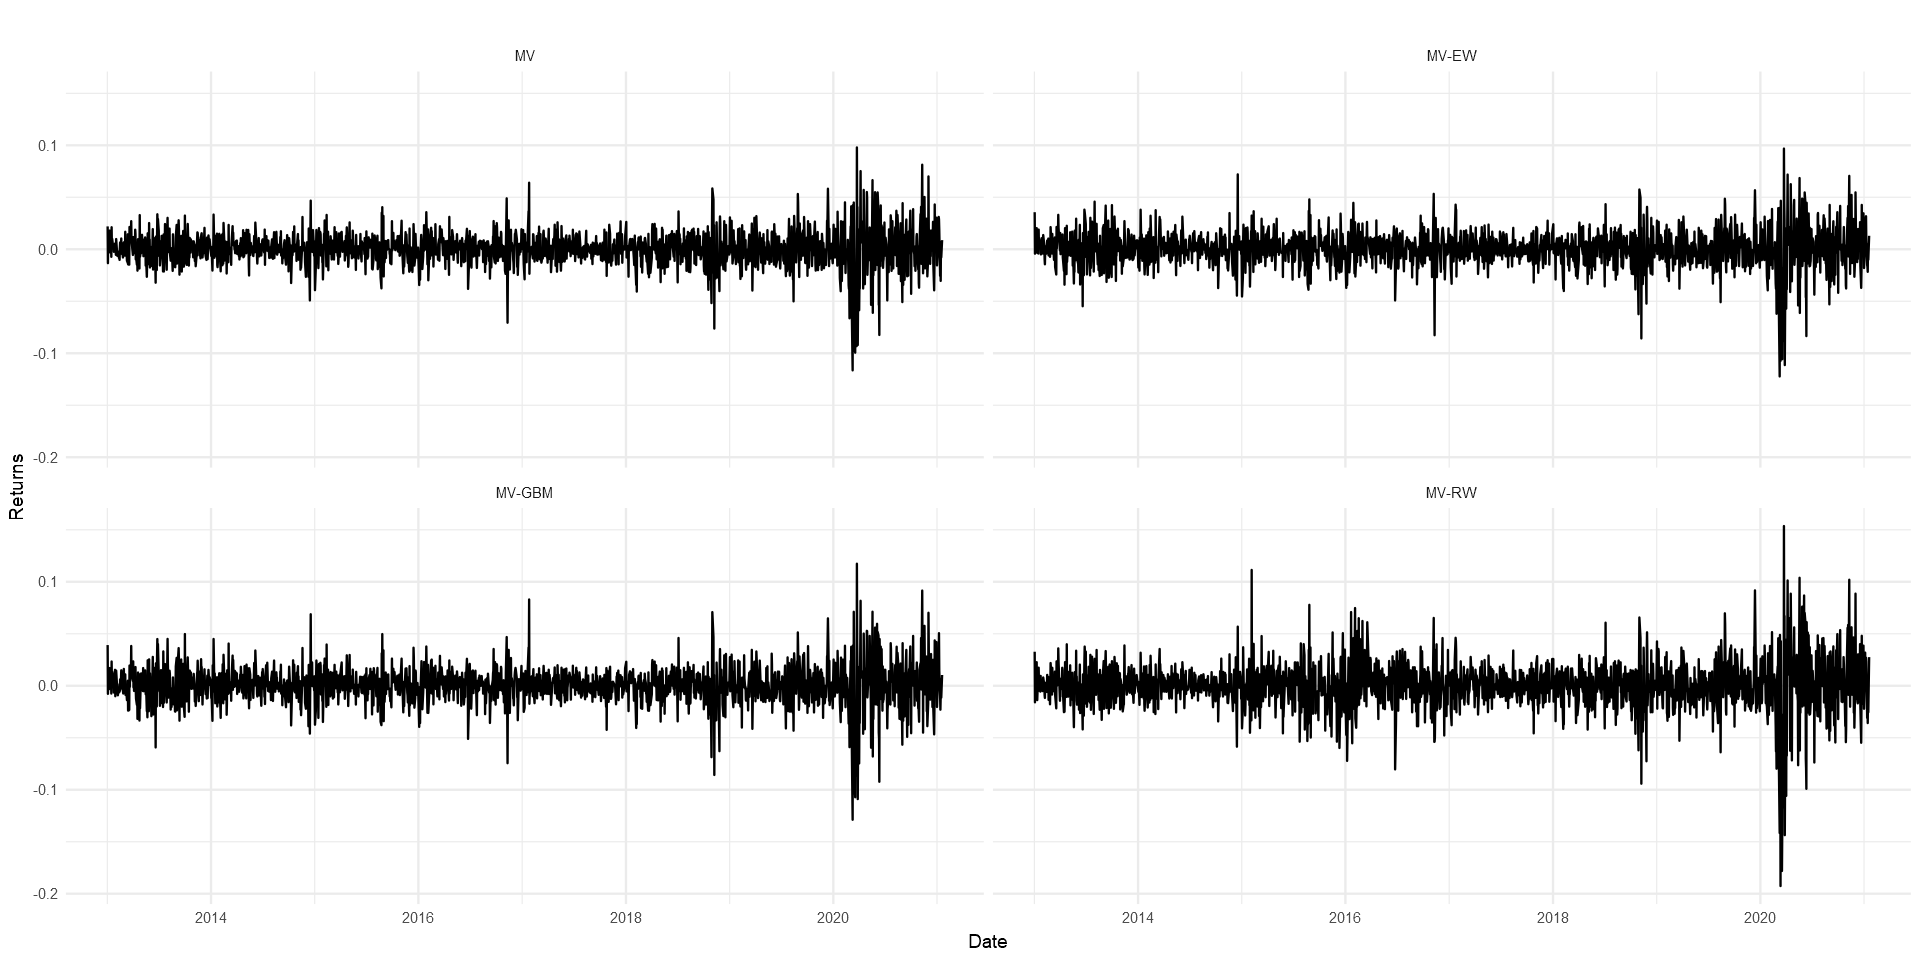

In [89]:
#  returns   
base.ret <- portfolio.ret %>%
  gather(key='Modelo',value='portfolio.return',-date)

# portfolio returns
p2 <- ggplot(base.ret , aes(x=date,y=portfolio.return) )+
  geom_line() +
  theme_minimal() +
  labs(title="",x='Date',y='Returns') +
  facet_wrap(vars(Modelo)) 
p2

In [90]:
# Global Sharpe ratio
mean_port <- base.ret %>% 
  group_by(Modelo) %>% 
  summarize(mean=mean(portfolio.return),
            sd = sd(portfolio.return),
            SharpeRatio = mean/sd) %>%
  ungroup() %>%
  data.frame() %>%
  arrange(desc(SharpeRatio))
mean_port

Modelo,mean,sd,SharpeRatio
<chr>,<dbl>,<dbl>,<dbl>
MV-GBM,0.0005062232,0.01818867,0.02783179
MV,0.0004546123,0.01645440,0.02762861
MV-EW,0.0004243977,0.01742879,0.02435038
MV-RW,0.0003829715,0.02320628,0.01650293


In [91]:
#  Sharpe Ratio df
sharpe.ratio <- portfolio.ret %>% 
  gather(key='Modelo',value='returns',-date) %>%
  mutate(year = substring(date,1,4)) %>% 
  dplyr::select(-date,Modelo,year,returns) %>%
  group_by(Modelo,year) %>%
  summarise(mean=mean(returns),sd=sd(returns)) %>%
  ungroup() %>%
  data.frame() %>%
  mutate(sharpe=mean/sd) %>%
  filter(year < '2021') 

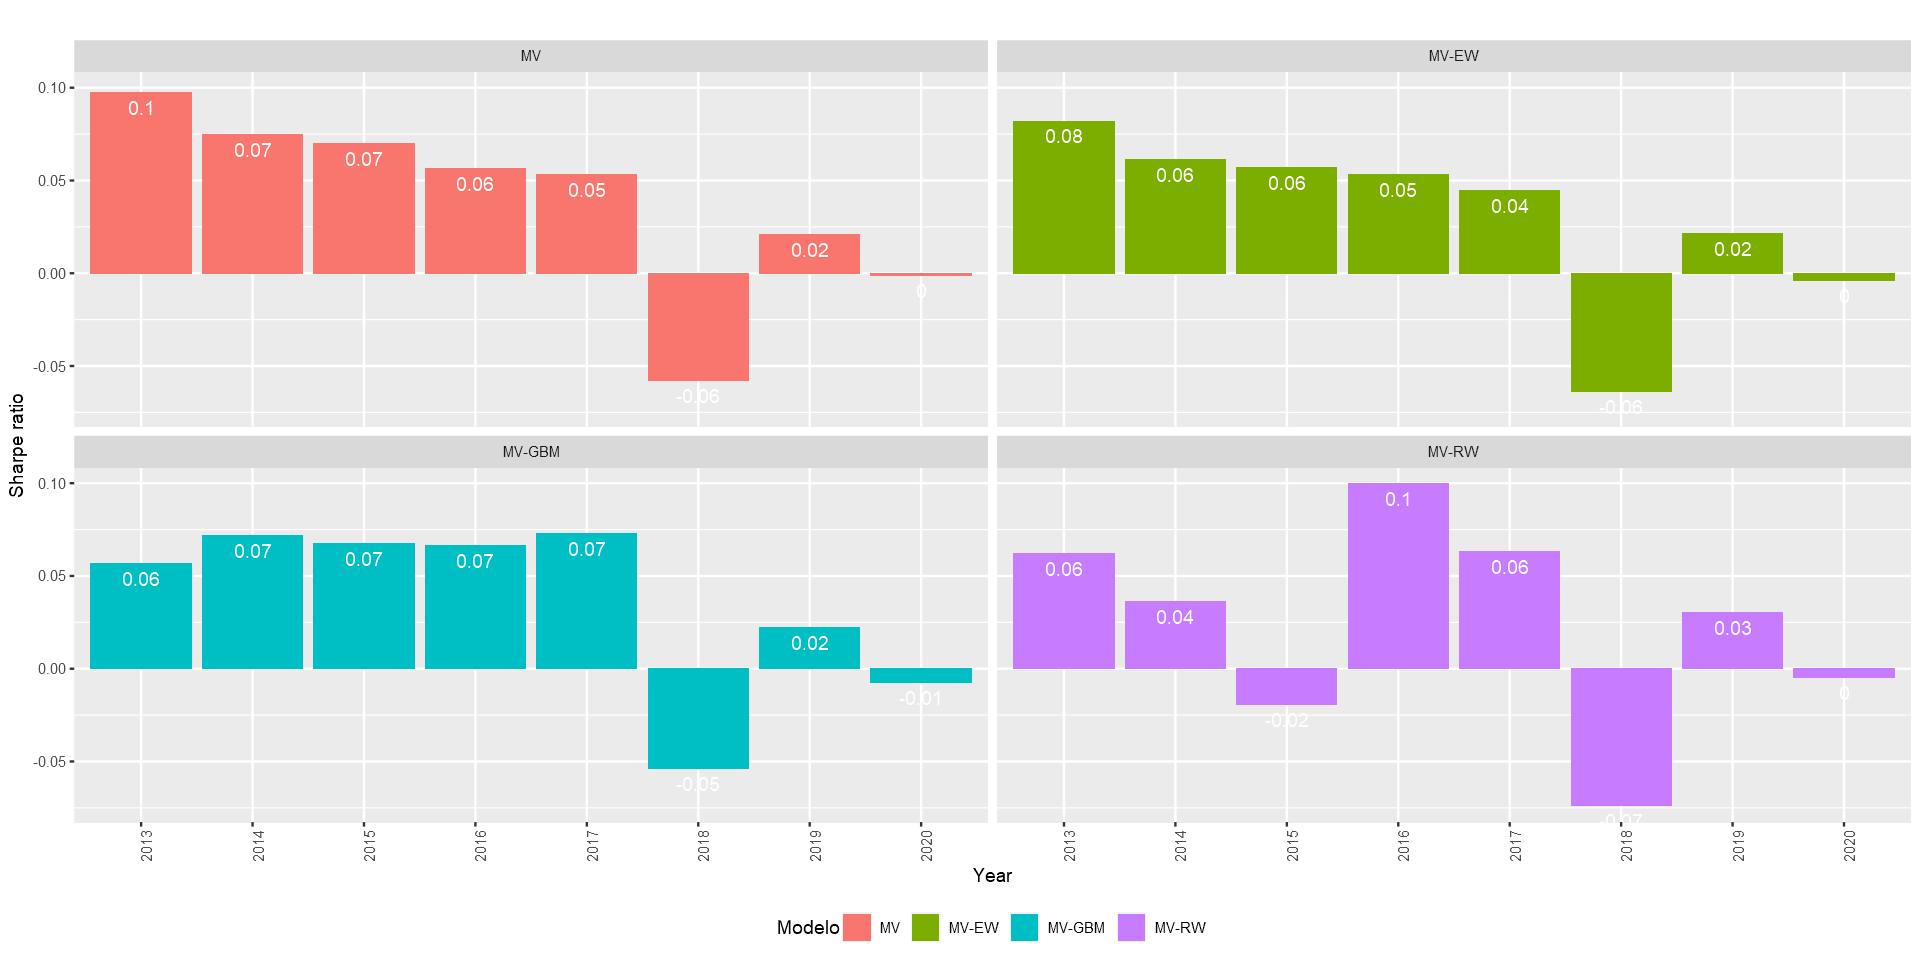

In [92]:
# Sharpe ratio plot
p4 <- ggplot(sharpe.ratio,aes(x=year,y=sharpe,fill=Modelo)) +
  geom_col(position=position_dodge()) +
  labs(title="",x='Year',y='Sharpe ratio') +
  facet_wrap(vars(Modelo)) +
  geom_text(aes(label=round(sharpe,2)), vjust=1.6, color="white", size=4) +
  theme(legend.position="bottom",
        axis.text.x = element_text(angle = 90))
  
p4

In [93]:
# Sharpe ratio table
sharpe.ratio.table <- portfolio.ret %>% 
  gather(key='Modelo',value='returns',-date) %>%
  mutate(year = substring(date,1,4)) %>%  # month = substring(date,6,7)
  dplyr::select(-date,Modelo,year,returns) %>%
  group_by(Modelo,year) %>%
  summarise(mean=mean(returns),sd=sd(returns)) %>%
  ungroup() %>%
  data.frame() %>%
  mutate(sharpe=mean/sd) %>%
  dplyr::select(-mean,-sd) %>%
  filter(year < '2021') %>%
  spread(key=Modelo,value=sharpe)
sharpe.ratio.table

year,MV,MV-EW,MV-GBM,MV-RW
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2013,0.097611288,0.082059304,0.056793444,0.06219480
2014,0.074760024,0.061491184,0.071853843,0.03643327
2015,0.069948966,0.056843152,0.067534696,-0.01950578
2016,0.056648854,0.053394448,0.066277882,0.10004387
2017,0.053400929,0.044690025,0.073082211,0.06322335
2018,-0.057958788,-0.063675518,-0.053595966,-0.07395606
2019,0.020955955,0.021289389,0.022078763,0.03032011
2020,-0.001421935,-0.003877161,-0.007311116,-0.00478630


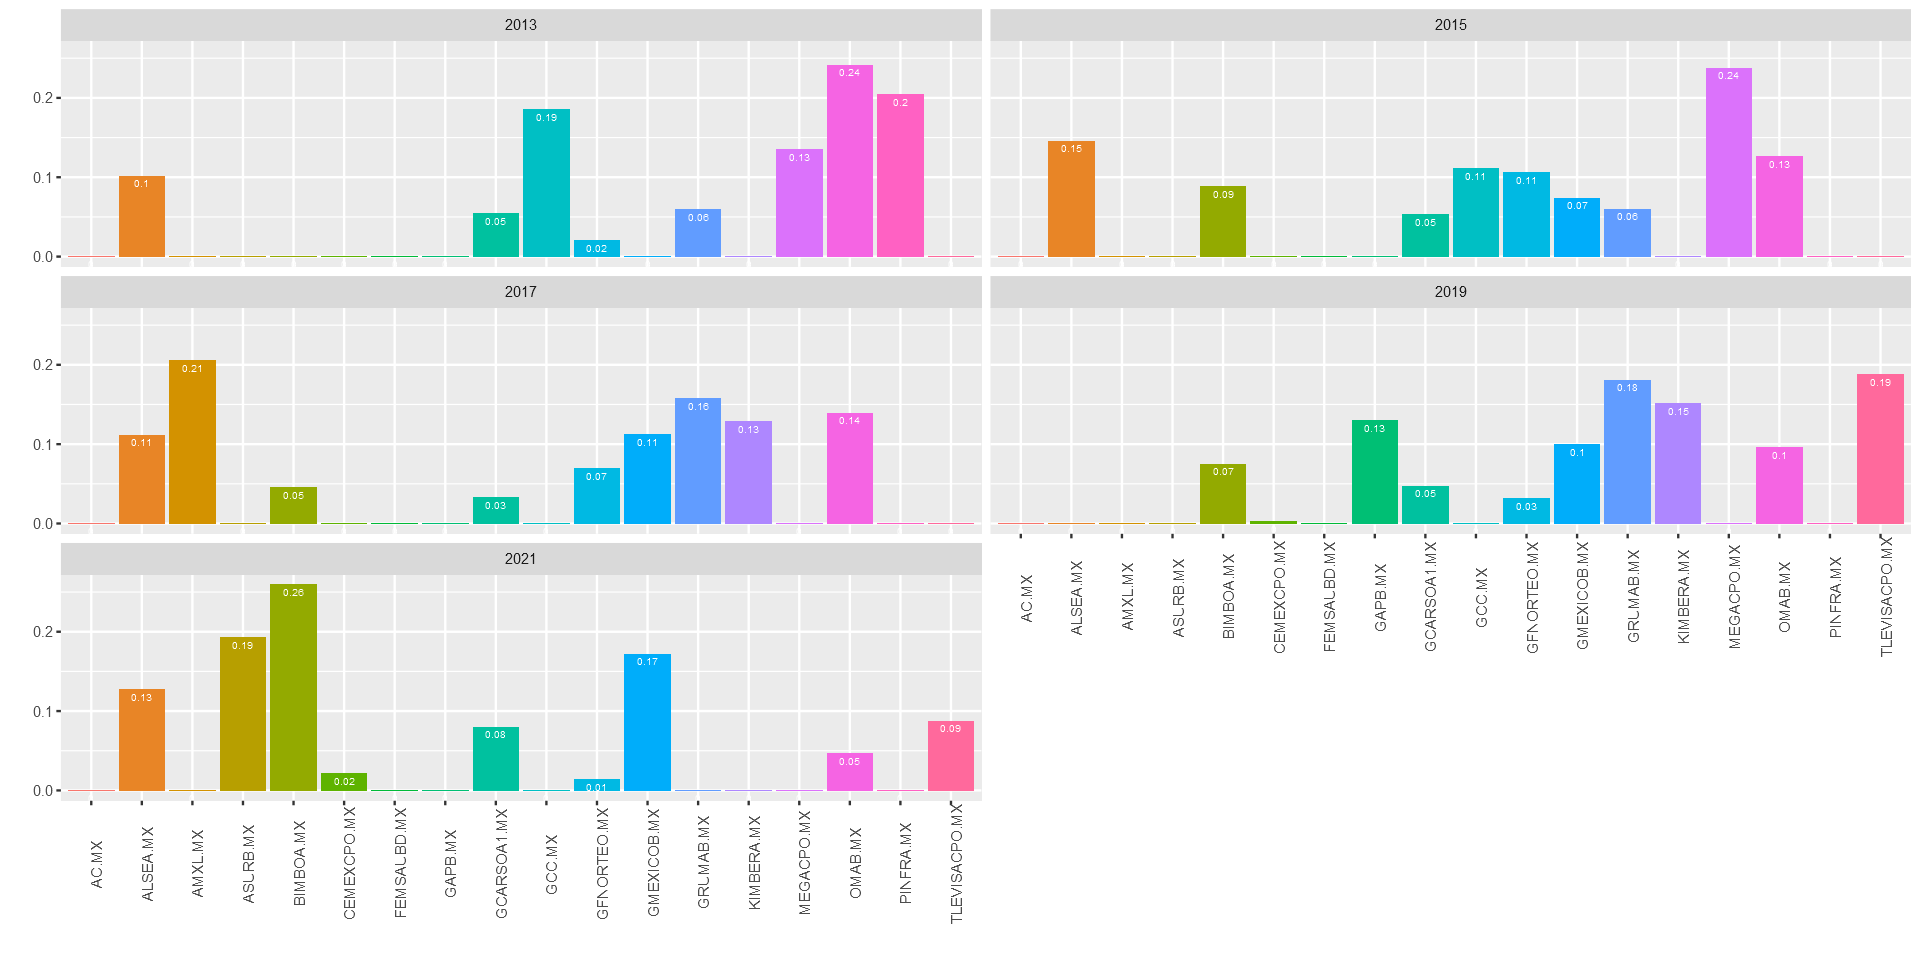

In [94]:
#  Weights
df_weights <- port.mv$df_min_weights %>%
  gather(key='asset',value='valor',-year) %>%
  mutate(year = substring(year,1,4)) 

p5 <- ggplot(df_weights,aes(x=asset,y=valor,fill=asset)) +
  geom_col(position=position_dodge()) +
  labs(x='',y='') +
  facet_wrap(vars(year),ncol=2) +
  geom_text(aes(label=round(valor,2)), vjust=1.6, color="white", size=2) +
  theme(legend.position="none",
        legend.title = element_blank(),
        axis.text.x = element_text(angle = 90))
p5

In [95]:
# weights for each rebalance period
df_weights <- port.mv$df_min_weights %>%
  gather(key='asset',value='valor',-year) %>%
  mutate(year = substring(year,1,4)) %>%
  spread(asset,valor)
df_weights

year,AC.MX,ALSEA.MX,AMXL.MX,ASURB.MX,BIMBOA.MX,CEMEXCPO.MX,FEMSAUBD.MX,GAPB.MX,GCARSOA1.MX,GCC.MX,GFNORTEO.MX,GMEXICOB.MX,GRUMAB.MX,KIMBERA.MX,MEGACPO.MX,OMAB.MX,PINFRA.MX,TLEVISACPO.MX
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2013,0,0.1016,0.0000,0.0000,0.0000,0.0000,0,0.00,0.0539,0.1853,0.0197,0.0000,0.0591,0.0000,0.1346,0.2413,0.2045,0.0000
2015,0,0.1456,0.0000,0.0000,0.0880,0.0000,0,0.00,0.0528,0.1111,0.1060,0.0737,0.0597,0.0000,0.2374,0.1258,0.0000,0.0000
2017,0,0.1113,0.2051,0.0000,0.0454,0.0000,0,0.00,0.0323,0.0000,0.0689,0.1121,0.1573,0.1286,0.0000,0.1391,0.0000,0.0000
2019,0,0.0000,0.0000,0.0000,0.0750,0.0020,0,0.13,0.0470,0.0000,0.0317,0.0998,0.1807,0.1511,0.0000,0.0954,0.0000,0.1874
2021,0,0.1273,0.0000,0.1925,0.2595,0.0213,0,0.00,0.0796,0.0000,0.0139,0.1719,0.0000,0.0000,0.0000,0.0466,0.0000,0.0873
